# Phase 1 - Data Acquisition and Refinement

The goals for Phase 1, per the roadmap in the readme, are as follows:

1. Obtain a dataset of news articles that includes the text content as well as a summary of each article. 
2. Explore the dataset to get a sense of the data, such as the number of articles, length of the articles and summaries, and distribution of topics and keywords.
3. Clean and preprocess the data to remove unnecessary characters, punctuation, and stop words. 
4. Tokenize the text into words or subwords, and create input sequences and output summaries.

## Goal 1: Obtain a Dataset

We've obtained a dataset from Kaggle that contains 870,521 articles, each of which has a text content and a summary. The text content is the full article, and the summary is a short version of the article that summarizes the main points.

For more information on the dataset, please see the dataset section in `README.md`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import string
import nltk
from nltk import WhitespaceTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
df = pd.read_csv('data/news_summarization.csv') # expect this step to take about 30 seconds

## Goal 2: Explore the Dataset

We've explored the dataset and found the following information:
- Total of 870,521 articles
- Only 580,013 unique articles (about 1/3 of the articles are duplicates)
- The most frequently occurring words are generic words like "this", "that", "the", "a", "an", etc.
  - Should we remove these words from the dataset?

The dataset contains the following columns:
- `Unnamed: 0` - index, can be ignored
- `ID` - unique ID for each article (appears to be a generated UUID)
- `Content` - the text content of the article
- `Summary` - the summary of the article
- `Dataset` - the dataset that the article came from (XSum, CNN/Daily Mail, Multi-News)

In [29]:
df = df.drop(df.columns[0], axis=1) # unused index column
df.head()

,ID,Content,Summary,Dataset
0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870521 entries, 0 to 870520
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ID       814305 non-null  object
 1   Content  870487 non-null  object
 2   Summary  870521 non-null  object
 3   Dataset  870521 non-null  object
dtypes: object(4)
memory usage: 26.6+ MB


In [4]:
# Let's find the average of the Content and Summary columns
# 
# We can't analyze the entire dataset because it's too large, so we'll take a sample of 1000 rows.
df_sample = df.sample(1000)

In [23]:
data = [
    df_sample['Content'].apply(len),
    df_sample['Summary'].apply(len),
    df_sample['Content'].apply(lambda x: len(x.split())),
    df_sample['Summary'].apply(lambda x: len(x.split())),
    df_sample['Content'].apply(lambda x: len(x.split('.'))),
    df_sample['Summary'].apply(lambda x: len(x.split('.')))
]

sample = pd.DataFrame(data, index=['Content Length', 'Summary Length', 'Content Words', 'Summary Words', 'Content Sentences', 'Summary Sentences']).T.describe().round(2)

sample.loc['mean']

Content Length       3892.02
Summary Length        309.98
Content Words         661.25
Summary Words          53.48
Content Sentences      39.63
Summary Sentences       4.49
Name: mean, dtype: float64

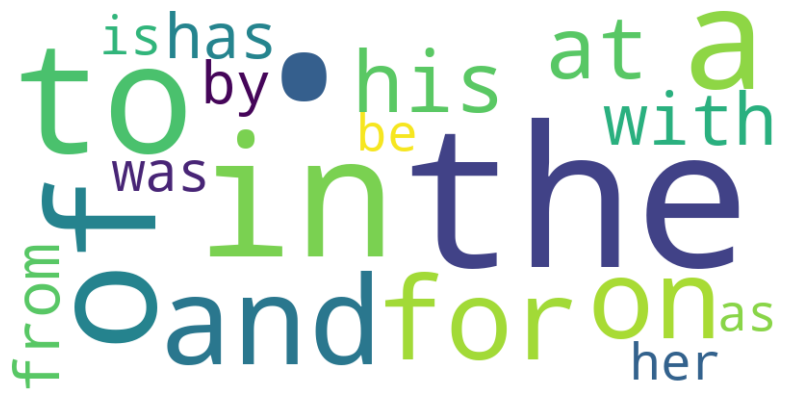

In [5]:
# Now let's look at distribution of topics and keywords.
#
# The dataset doesn't provide topics, so we'll parse keywords from the summary column.
df_sample2 = df.sample(10000)
df_sample2['Keywords'] = df_sample2['Summary'].apply(lambda x: x.split()[-5:])

# Now let's list all the keywords and their frequencies.
keywords = []
for i in df_sample2['Keywords']:
    keywords.extend(i)

keywords = pd.Series(keywords).value_counts()

# Let's plot the top 20 keywords as a word cloud.
# keywords = keywords[20:]
wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white').generate_from_frequencies(keywords)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Goal 3: Clean and Preprocess the Data

We'll clean and preprocess the data by removing articles that are duplicates or empty.

I considered removing unnecessary punctuation and filler words, but I decided against it because I think it would be better to leave the data as-is and let the model learn how to handle these words. For example, if we remove the word "the", then the model will not be able to learn that "the" is a filler word and should be ignored.

If the results are not good enough, then we can try removing unnecessary punctuation and filler words.

In [30]:
df = df.drop_duplicates(subset=['Content', 'Summary'])
df = df.dropna(axis=0, how='any')

## Goal 4: Tokenize the Text

We'll tokenize the text by splitting the text into words and creating input sequences and output summaries. We'll also create a dictionary that maps each word to a unique integer. We'll use this dictionary to convert the words in the input sequences and output summaries to integers.

We'll also create a reverse dictionary that maps each integer back to the original word. We'll use this reverse dictionary to convert the integers back to words.

We'll also create a dictionary that maps each word to the number of times it appears in the dataset. We'll use this dictionary to filter out words that appear less than a certain number of times.

In [31]:
# lowercase then remove stopwords

df['Content_Tokens'] = df['Content'].apply(lambda x: x.lower())
df['Summary_Tokens'] = df['Summary'].apply(lambda x: x.lower())

stop = stopwords.words('english')

df['Summary_Tokens'] = df['Summary_Tokens'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['Content_Tokens'] = df['Content_Tokens'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head(3)

,ID,Content,Summary,Dataset,Content_Tokens,Summary_Tokens
0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail,new york police concerned drones could become ...,police investigated criminals rigged guns dron...
1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail,. ryan lipman . perhaps australian porn star a...,porn star angela white secretly filmed sex act...
2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail,"was, sergio garcia conceded, much like hunted ...",american draws inspiration fellow countryman o...


In [32]:
# create tokens

tk = WhitespaceTokenizer()

df['Summary_Tokens'] = df['Summary_Tokens'].apply(lambda x: tk.tokenize(x))
df['Content_Tokens'] = df['Content_Tokens'].apply(lambda x: tk.tokenize(x))

df.head(3)

,ID,Content,Summary,Dataset,Content_Tokens,Summary_Tokens
0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail,"[new, york, police, concerned, drones, could, ...","[police, investigated, criminals, rigged, guns..."
1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail,"[., ryan, lipman, ., perhaps, australian, porn...","[porn, star, angela, white, secretly, filmed, ..."
2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail,"[was,, sergio, garcia, conceded,, much, like, ...","[american, draws, inspiration, fellow, country..."


In [33]:
# lemmatize and remove punctuation from series

lemmatizer = WordNetLemmatizer()

def lemmatize_ser(ser):
    for i_l, l in enumerate(ser):
        for i_w, w in enumerate(l):
            ser.iloc[i_l][i_w]= lemmatizer.lemmatize(w)
            ser.iloc[i_l][i_w]= w.translate(str.maketrans('', '', string.punctuation))
            
lemmatize_ser(df['Summary_Tokens'])
lemmatize_ser(df['Content_Tokens'])

df.head(3)

,ID,Content,Summary,Dataset,Content_Tokens,Summary_Tokens
0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail,"[new, york, police, concerned, drones, could, ...","[police, investigated, criminals, rigged, guns..."
1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail,"[, ryan, lipman, , perhaps, australian, porn, ...","[porn, star, angela, white, secretly, filmed, ..."
2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail,"[was, sergio, garcia, conceded, much, like, hu...","[american, draws, inspiration, fellow, country..."


In [34]:
# remove empty list elements from tokens

df['Summary_Tokens'] = df['Summary_Tokens'].apply(lambda l: list(filter(None, l)))
df['Content_Tokens'] = df['Content_Tokens'].apply(lambda l: list(filter(None, l)))

df.head(3)

,ID,Content,Summary,Dataset,Content_Tokens,Summary_Tokens
0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail,"[new, york, police, concerned, drones, could, ...","[police, investigated, criminals, rigged, guns..."
1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail,"[ryan, lipman, perhaps, australian, porn, star...","[porn, star, angela, white, secretly, filmed, ..."
2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail,"[was, sergio, garcia, conceded, much, like, hu...","[american, draws, inspiration, fellow, country..."


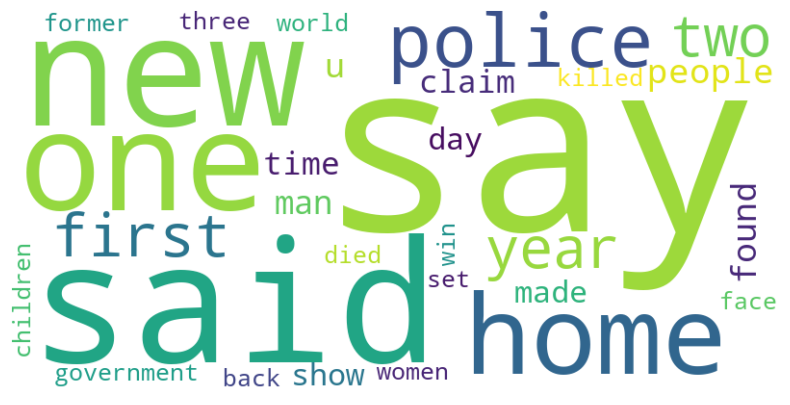

In [20]:
# create wordcloud of summary tokens

# sample df to generate wordcloud from
wc_df = df.sample(10000)

# create string of summary tokens for input as wordcloud 
tokens = ''
for x in wc_df['Summary_Tokens']: tokens += x
tokens = tokens.translate(str.maketrans('', '', string.punctuation)) 

# generate wc
wc = WordCloud(width=800, height=400, max_words=30, background_color='white').generate(tokens)

# plot wc
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# export preprocessed data
df.to_csv('data/clean_data.csv')